In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import field, asdict, dataclass
from typing import List
from benchmarks.benchmark_utils import RequestFuncOutput
from benchmarks.benchmark_workload_gen import *

In [2]:
def retrive_request_outputs(path):
    with open(path, 'r') as file:
        data = json.load(file)
        outputs = [RequestFuncOutput(**d) for d in data]
    return outputs

In [3]:
def lat_tpot_ttft(outputs: List[RequestFuncOutput], match = None):
    if not match:
        match = lambda o: True
    outputs = [o for o in outputs if match(o)]
    lats = [o.request_latency for o in outputs if o.request_latency]
    tpots = [o.tpot for o in outputs if o.tpot]
    ttfts = [o.ttft for o in outputs if o.ttft]
    lat_p50, lat_p90, lat_p99 = np.percentile(lats, [50, 90, 99])
    tpot_p50, tpot_p90, tpot_p99 = np.percentile(tpots, [50, 90, 99])
    ttft_p50, ttft_p90, ttft_p99 = np.percentile(ttfts, [50, 90, 99])
    
    print(f"Num finished: {len([o for o in outputs if o.success])}")
    print(f'Latency: p50={lat_p50:.2f}, p90={lat_p90:.2f}, p99={lat_p99:.2f}')
    print(f'TPOT: p50={tpot_p50:.2f}, p90={tpot_p90:.2f}, p99={tpot_p99:.2f}')
    print(f'TTFT: p50={ttft_p50:.2f}, p90={ttft_p90:.2f}, p99={ttft_p99:.2f}')
    
    fig, axs = plt.subplots(1,3, figsize=(16, 4))
    sns.kdeplot(x=lats,  ax=axs[0], cumulative=True).set_title('Latency')
    sns.kdeplot(x=tpots, ax=axs[1], cumulative=True).set_title('TPOT')
    sns.kdeplot(x=ttfts, ax=axs[2], cumulative=True).set_title('TTFT')
    
def ttft_slo(outputs, slo):
    ttfts = [o.ttft for o in outputs if o.ttft]
    slo_ttfts = [1 for ttft in ttfts if ttft <= slo]
    return sum(slo_ttfts) / len(ttfts)

def windowed_metric(start, end, outputs: List[RequestFuncOutput], exp_time, match = None):
    if not match:
        match = lambda o: True
    within_window = [o for o in outputs if o.send_out_time >= start and o.send_out_time <= end and match(o)]
    lats = [o.request_latency if o.success else exp_time - o.send_out_time for o in within_window]
    tpots = [o.tpot for o in within_window if o.tpot]
    ttfts = [o.ttft if o.ttft else exp_time - o.send_out_time for o in within_window]
    lat_p50, lat_p90, lat_p99 = np.percentile(lats, [50, 90, 99])
    tpot_p50, tpot_p90, tpot_p99 = np.percentile(tpots, [50, 90, 99])
    ttft_p50, ttft_p90, ttft_p99 = np.percentile(ttfts, [50, 90, 99])
    avg_lat, avg_tpot, avg_ttft = np.mean(lats), np.mean(tpots), np.mean(ttfts)
    
    print('-'*20)
    print(f"Requests within window: {len(within_window)}")
    print(f"Num finished: {len([o for o in within_window if o.success])}")
    print(f'Latency: p50={lat_p50:.2f}, p90={lat_p90:.2f}, p99={lat_p99:.2f}')
    print(f'TPOT: p50={tpot_p50:.2f}, p90={tpot_p90:.2f}, p99={tpot_p99:.2f}')
    print(f'TTFT: p50={ttft_p50:.2f}, p90={ttft_p90:.2f}, p99={ttft_p99:.2f}')
    print(f'Avg Latency: {avg_lat:.2f}, Avg TPOT: {avg_tpot:.2f}, Avg TTFT: {avg_ttft:.2f}')
    print('-'*20)

In [53]:
is_cold = lambda o: not WorkloadPrefixDataLoader.is_hot(o)

In [10]:
ref_random = retrive_request_outputs('/mnt/ssd1/alm-os/sglang_multi_model/logs/ref_log_16K_2r_1800_rps_2/mistralai-Mistral-7B-v0.1_24_0.5_600_2_DataParallelRuntimeSelectionPolicy.RANDOM-None:4r_300.json')
sim_random = retrive_request_outputs('/mnt/ssd1/alm-os/sglang_multi_model/logs/sim_queue_event_log_16K_2r_1800_rps_2/mistralai-Mistral-7B-v0.1_24_0.5_600_2_DataParallelRuntimeSelectionPolicy.RANDOM-None:4r_300.json')
sim_sleep_random = retrive_request_outputs('/mnt/ssd1/alm-os/sglang_multi_model/logs/sim_sleep_log_16K_2r_1800_rps_2/mistralai-Mistral-7B-v0.1_24_0.5_600_2_DataParallelRuntimeSelectionPolicy.RANDOM-None:4r_300.json')

Num finished: 25
Latency: p50=33.18, p90=154.11, p99=166.30
TPOT: p50=0.28, p90=0.43, p99=0.50
TTFT: p50=17.52, p90=139.95, p99=157.81
Num finished: 23
Latency: p50=33.61, p90=229.39, p99=269.93
TPOT: p50=0.28, p90=0.47, p99=0.49
TTFT: p50=13.84, p90=227.97, p99=265.89
Num finished: 22
Latency: p50=32.03, p90=166.56, p99=196.98
TPOT: p50=0.29, p90=0.43, p99=0.50
TTFT: p50=15.33, p90=144.59, p99=184.12


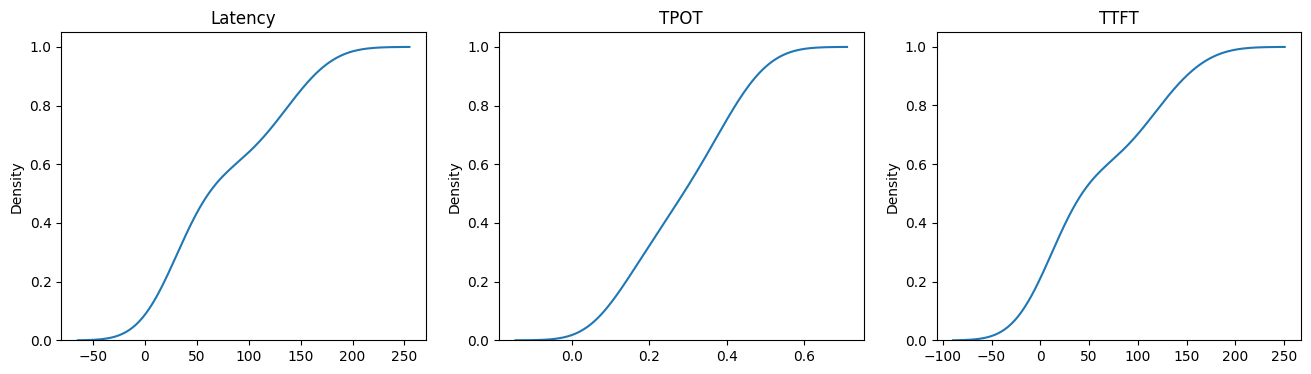

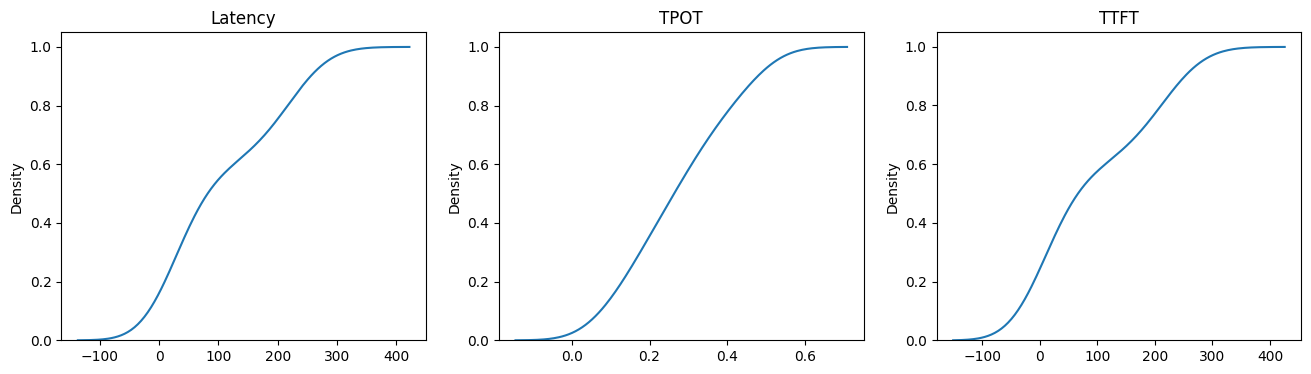

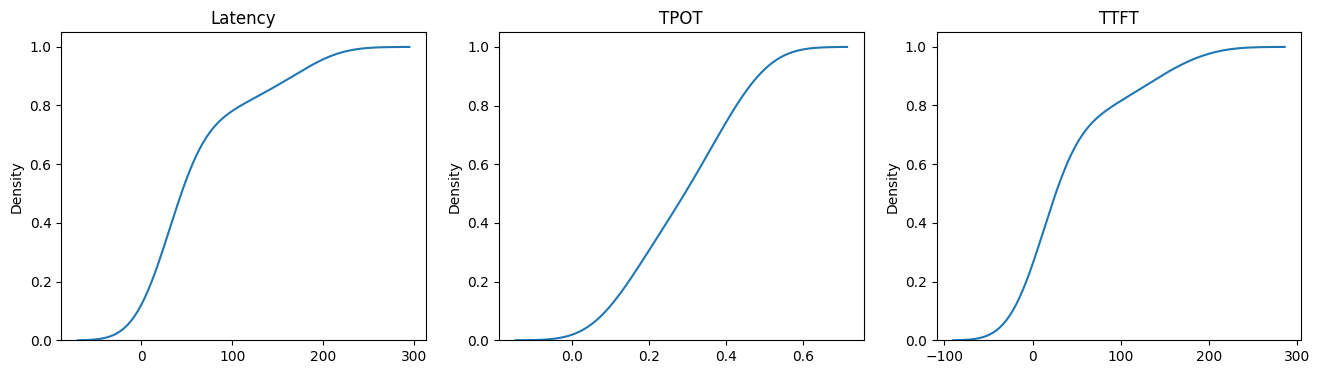

In [11]:
lat_tpot_ttft(ref_random, is_cold)
lat_tpot_ttft(sim_random, is_cold)
lat_tpot_ttft(sim_sleep_random, is_cold)

Num finished: 281
Latency: p50=29.52, p90=51.49, p99=97.46
TPOT: p50=0.26, p90=0.36, p99=0.45
TTFT: p50=12.11, p90=33.95, p99=82.34
Num finished: 288
Latency: p50=31.37, p90=55.26, p99=114.86
TPOT: p50=0.26, p90=0.39, p99=0.57
TTFT: p50=13.20, p90=40.30, p99=95.05
Num finished: 284
Latency: p50=29.17, p90=52.27, p99=100.73
TPOT: p50=0.25, p90=0.36, p99=0.43
TTFT: p50=12.55, p90=35.67, p99=83.36


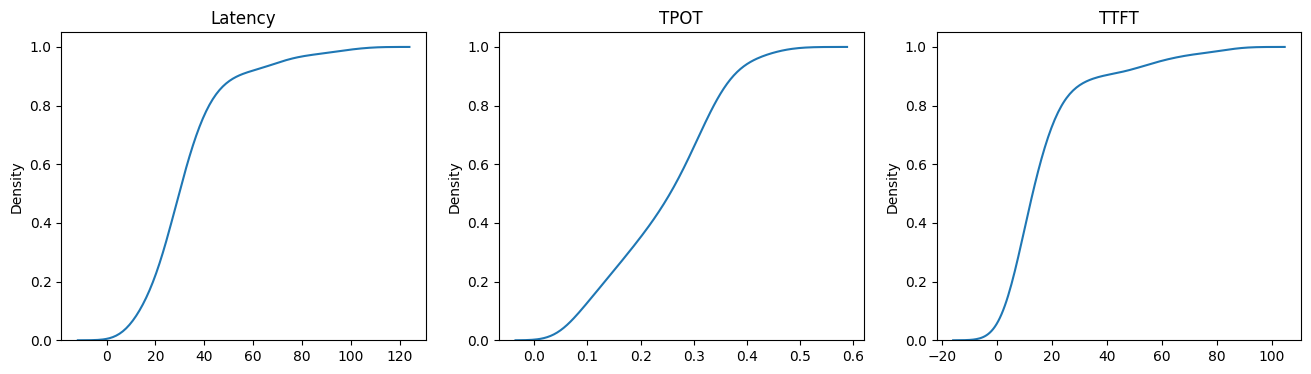

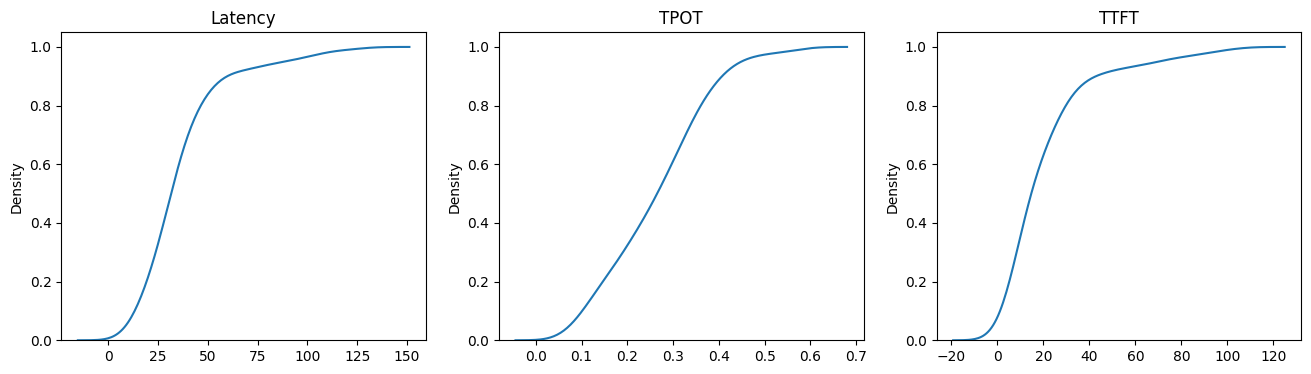

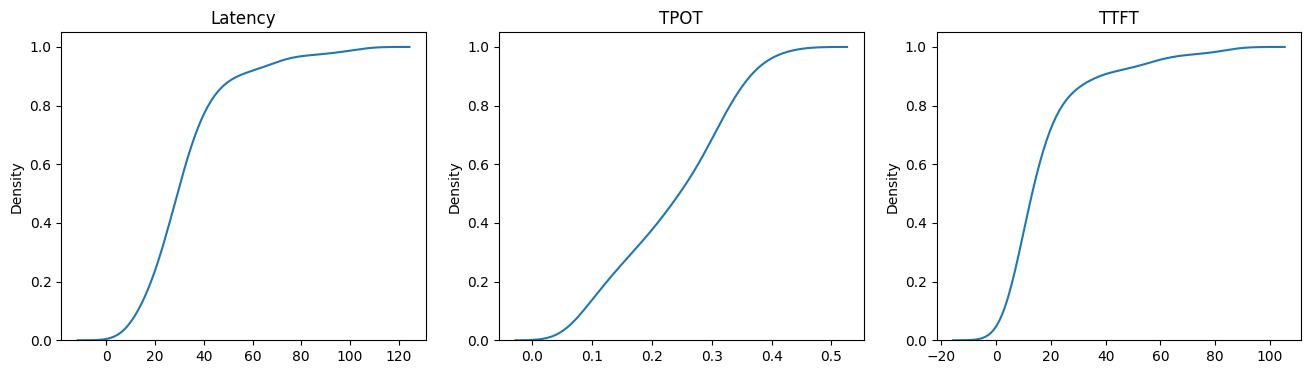

In [12]:
lat_tpot_ttft(ref_random, WorkloadPrefixDataLoader.is_hot)
lat_tpot_ttft(sim_random, WorkloadPrefixDataLoader.is_hot)
lat_tpot_ttft(sim_sleep_random, WorkloadPrefixDataLoader.is_hot)